[View in Colaboratory](https://colab.research.google.com/github/mogamin/chainer-examples/blob/master/chainer_PotatoChips_Classification_CNN.ipynb)

In [2]:
# 
#![ ! -e ./data ] && curl -L "https://rebrand.ly/dllab2018-hackathon-cv" -o data.tar.gz && gzip -d -c data.tar.gz | tar xf -

#!apt-get install -y -qq libcusparse8.0 libnvrtc8.0 libnvtoolsext1
#!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
#!pip install cupy-cuda80==4.3.0 
#!pip install chainer==4.3.0
#!pip install chainercv
#!python -c 'import chainer; chainer.print_runtime_info()'

import chainer
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True
Chainer: 4.3.0
NumPy: 1.14.5
CuPy:
  CuPy Version          : 4.3.0
  CUDA Root             : None
  CUDA Build Version    : 8000
  CUDA Driver Version   : 9000
  CUDA Runtime Version  : 8000
  cuDNN Build Version   : 7102
  cuDNN Version         : 7102
  NCCL Build Version    : 2212


In [0]:
# 画像データの前処理変換
import chainer
from chainercv.transforms import resize
from chainercv.transforms import random_flip
from chainercv.transforms import random_sized_crop

class ImageTransform(object):
    def __call__(self, in_data):
        img, label = in_data
        _, H, W = img.shape
        img = random_sized_crop(img)
        img = resize(img, (224, 224))
        img = random_flip(img, x_random=True)
        return img, label

In [0]:
# データのロード
from chainer.datasets import LabeledImageDataset
from chainer.datasets import TransformDataset

train = LabeledImageDataset('data/train/train_labels.txt', root='data/train/images/')
train = TransformDataset(train, ImageTransform())
valid = LabeledImageDataset('data/valid/valid_labels.txt', root='data/valid/images/')
valid = TransformDataset(valid, ImageTransform())

In [0]:
import chainer.links as L
import chainer.functions as F
from chainercv.links import VGG16

class Potato(chainer.Chain):

  def __init__(self, n_class=9):
    super(Potato, self).__init__()
    with self.init_scope():
      self.base = L.VGG16Layers()
      self.fc1 = L.Linear(None, 224)
      self.fc2 = L.Linear(None, 224)
      self.fc3 = L.Linear(None, n_class)
  
  def __call__(self, x):
    #h = F.max_pooling_2d(F.relu(self.conv1(x)), ksize=2, stride=2)
    #h = F.max_pooling_2d(F.relu(self.conv2(h)), ksize=2, stride=2)
    #h = F.max_pooling_2d(F.relu(self.conv3(h)), ksize=2, stride=2)
    #h = F.average_pooling_2d(F.relu(self.conv4(h)), ksize=2, stride=2)
    h = self.base(x, layers=['fc7'])['fc7']
    h = F.relu(self.fc1(h))
    h = F.relu(self.fc2(h))
    return self.fc3(h)

In [0]:
BATCHSIZE=20
EPOCH=10
GPUID=0

In [0]:
import random
import numpy as np

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(RANDOM_SEED)

In [0]:
train_iter = chainer.iterators.SerialIterator(train, BATCHSIZE)
valid_iter = chainer.iterators.SerialIterator(valid, BATCHSIZE, repeat=False, shuffle=False)

In [7]:
#
from chainer import cuda

vgg = Potato()
model = L.Classifier(vgg)
vgg.base.disable_update()

if GPUID >= 0:
  xp = cuda.cupy
  cuda.Device(GPUID).use()
  model.to_gpu(GPUID)
else:
  xp = np
  
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [8]:
#
from chainer.training import extensions

updater = chainer.training.StandardUpdater(train_iter, optimizer, device=GPUID)
trainer = chainer.training.Trainer(updater, (EPOCH, 'epoch'), out='result/potato')
trainer.extend(extensions.Evaluator(valid_iter, model, device=GPUID))
trainer.extend(extensions.LogReport(trigger=(1,'epoch')))
trainer.extend(extensions.PrintReport(['epoch','main/accuracy','validation/main/accuracy','main/loss','validation/main/loss','elapsed_time']), trigger=(1,'epoch'))
trainer.extend(extensions.ProgressBar(update_interval=100))
trainer.run()

     total [..................................................]  1.90%
this epoch [#########.........................................] 18.98%
       100 iter, 0 epoch / 10 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [#.................................................]  3.80%
this epoch [##################................................] 37.97%
       200 iter, 0 epoch / 10 epochs
   0.76599 iters/sec. Estimated time to finish: 1:50:16.238389.
     total [##................................................]  5.69%
this epoch [############################......................] 56.95%
       300 iter, 0 epoch / 10 epochs
   0.76626 iters/sec. Estimated time to finish: 1:48:03.437486.
     total [###...............................................]  7.59%
this epoch [#####################################.............] 75.93%
       400 iter, 0 epoch / 10 epochs
   0.76279 iters/sec. Estimated time to finish: 1:46:21.807955.
     total [####...................

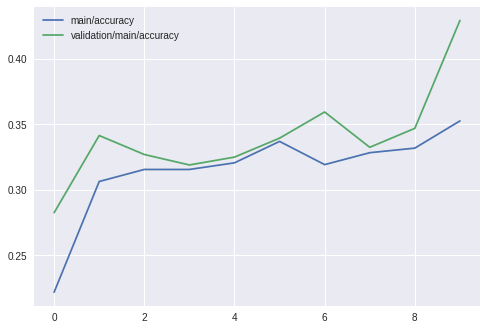

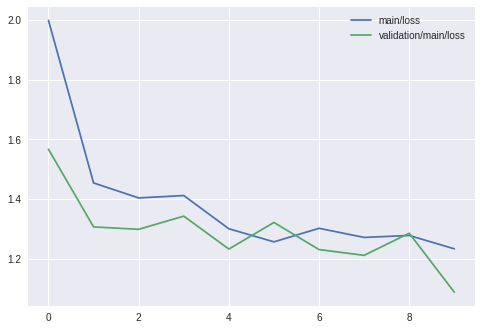

In [9]:
import json
import pandas as pd
with open('result/potato/log') as f:
  result = pd.DataFrame(json.load(f))

result[['main/accuracy','validation/main/accuracy']].plot()
result[['main/loss','validation/main/loss']].plot()

In [10]:
  import os
  
  # Evaluate on test dataset
  test = LabeledImageDataset('data/test/test_labels.txt', root='data/test/images')
  test = TransformDataset(test, ImageTransform())
  test_iter = chainer.iterators.SerialIterator(test, BATCHSIZE, repeat=False, shuffle=False)
  test_evaluator = extensions.Evaluator(test_iter, model, device=GPUID)
  results = test_evaluator()

  msg = 'Test loss\t:{}\n'.format(results['main/loss'])
  msg += 'Test accuracy\t:{}'.format(results['main/accuracy'])
  print(msg)
  print(msg, file=open(os.path.join('./', 'test_result.txt'), 'w'))

  chainer.serializers.save_npz(os.path.join('./', 'model_iter_{}'.format(updater.iteration)), model)

Test loss	:1.0861776
Test accuracy	:0.4333125
